## For Gradient Free Approach (COBYLA)

In [29]:
#importing the networkx library
import networkx as nx
import random
import numpy as np
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
from qiskit_algorithms.optimizers import COBYLA


m = 3  # layers
A = np.zeros([m+2,100])

for ii in range(100):
    A[0][ii] = ii+1
    n = 10  # nodes
    G= nx.erdos_renyi_graph(n,0.5)

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(1.0, 1.0)

    w = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i][j] = temp["weight"]

    quadratic_program = Maxcut(w).to_quadratic_program()

    optimizer = COBYLA()  # Gradient free optimizer
    sampler = Sampler()

    # Use QAOA
    for jj in range(m):
        qaoa = QAOA(sampler, optimizer, reps=jj+1)  # Using 1,2,...,m layers

        # Get the operator and offset
        op, offset = quadratic_program.to_ising()

        # Run the QAOA algorithm
        qaoa_result = qaoa.compute_minimum_eigenvalue(op)
        eigenstate = qaoa_result.eigenstate

        # Extract the most likely state
        sorted_counts = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True)
        most_likely_state = sorted_counts[0][0]  # Get the bitstring with the highest probability
        #print("Most likely state (bitstring):", most_likely_state)

        # Convert the bitstring into a binary array
        solution = np.array([int(bit) for bit in reversed(list(bin(most_likely_state)[2:].zfill(n)))])

        # Print the solution
        cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]

        A[jj+1][ii] = len(cut_edges)

    #classical program
    sol = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        Cut_value = 0
        for i in range(n):
            for j in range(n):
                Cut_value += w[i][j]*x[i]*(1-x[j])
        if sol < Cut_value:
            sol = Cut_value
            xlist = x
    
    A[m+1][ii] = int(sol)

C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\602134582.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\602134582.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\602134582.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` 

plot for Erdős Rényi graphs of 10 nodes using Gradient free optimizer

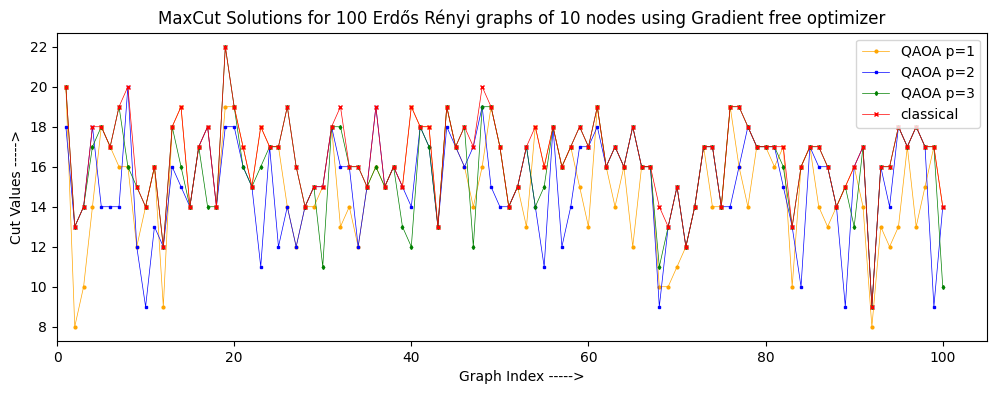

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  # Width: 12 inches, Height: 4 inches
plt.xlim(0,105)
plt.plot(A[0], A[1], label='QAOA p=1', marker='o', markersize=2, linewidth=0.5, color='orange') 
plt.plot(A[0], A[2], label='QAOA p=2', marker='s', markersize=2, linewidth=0.5, color='blue') 
plt.plot(A[0], A[3], label='QAOA p=3', marker='d', markersize=2, linewidth=0.5, color='green') 
plt.plot(A[0], A[4], label='classical', marker='x', markersize=3, linewidth=0.5, color='red') 

#plt.grid()
plt.xlabel("Graph Index ----->")
plt.ylabel("Cut Values ----->")
plt.title("MaxCut Solutions for 100 Erdős Rényi graphs of 10 nodes using Gradient free optimizer")
plt.legend(loc='upper right')
plt.savefig('non_grad_100_graphs.png', dpi=600)

Plotting bar plot for average normalized maxcut for different methods

For Non-Gradient based Maxcut normalized wrt classical method :  [1.0, 0.9170845504684513, 0.9196044925147091, 0.9678472652218781]


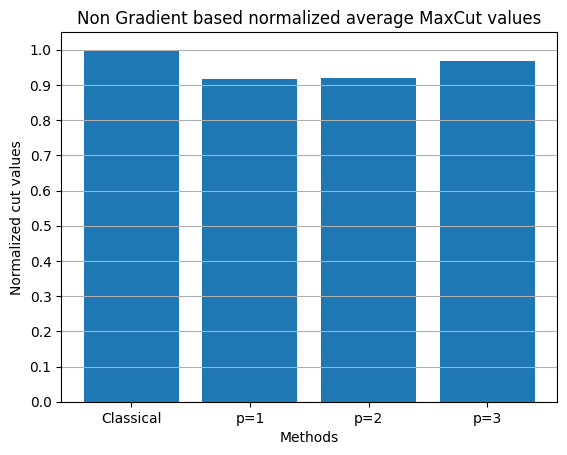

In [60]:
C = [1.]
for j in range(0,3,1):
    s = 0
    for i in range(0,100,1):
        s += A[j+1][i]/A[4][i]
    s = s/100
    C.append(float(s)) 
E = ['Classical','p=1','p=2','p=3']
print("For Non-Gradient based Maxcut normalized wrt classical method : ",C)
plt.bar(E,C)
plt.title('Non Gradient based normalized average MaxCut values')
plt.xlabel("Methods")
plt.grid(axis='y')
plt.ylabel("Normalized cut values")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig('Non_grad_bar_plot.png', dpi=600)

## For Gradient Based Approch (BFGS)

In [2]:
#importing the networkx library
import networkx as nx
import random
import numpy as np
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_optimization.applications import Maxcut
from qiskit_algorithms.optimizers import L_BFGS_B


m = 3  # layers
B = np.zeros([m+2,100])

for ii in range(100):
    B[0][ii] = ii+1
    n = 10  # nodes
    G= nx.erdos_renyi_graph(n,0.5)

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(1.0, 1.0)

    w = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i,j,default=0)
            if temp != 0:
                w[i][j] = temp["weight"]

    quadratic_program = Maxcut(w).to_quadratic_program()

    optimizer = L_BFGS_B()  # Gradient based optimizer
    sampler = Sampler()

    # Use QAOA
    for jj in range(m):
        qaoa = QAOA(sampler, optimizer, reps=jj+1)  # Using 1,2,...,m layers

        # Get the operator and offset
        op, offset = quadratic_program.to_ising()

        # Run the QAOA algorithm
        qaoa_result = qaoa.compute_minimum_eigenvalue(op)
        eigenstate = qaoa_result.eigenstate

        # Extract the most likely state
        sorted_counts = sorted(eigenstate.items(), key=lambda x: x[1], reverse=True)
        most_likely_state = sorted_counts[0][0]  # Get the bitstring with the highest probability
        #print("Most likely state (bitstring):", most_likely_state)

        # Convert the bitstring into a binary array
        solution = np.array([int(bit) for bit in reversed(list(bin(most_likely_state)[2:].zfill(n)))])

        # Print the solution
        cut_edges = [(i, j) for i, j in G.edges if solution[i] != solution[j]]

        B[jj+1][ii] = len(cut_edges)

    #classical program
    sol = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        Cut_value = 0
        for i in range(n):
            for j in range(n):
                Cut_value += w[i][j]*x[i]*(1-x[j])
        if sol < Cut_value:
            sol = Cut_value
            xlist = x
    
    B[m+1][ii] = int(sol)

C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\961734203.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\961734203.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\shubh\AppData\Local\Temp\ipykernel_1784\961734203.py:32: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` 

plot for Erdős Rényi graphs of 10 nodes using Gradient based optimizer

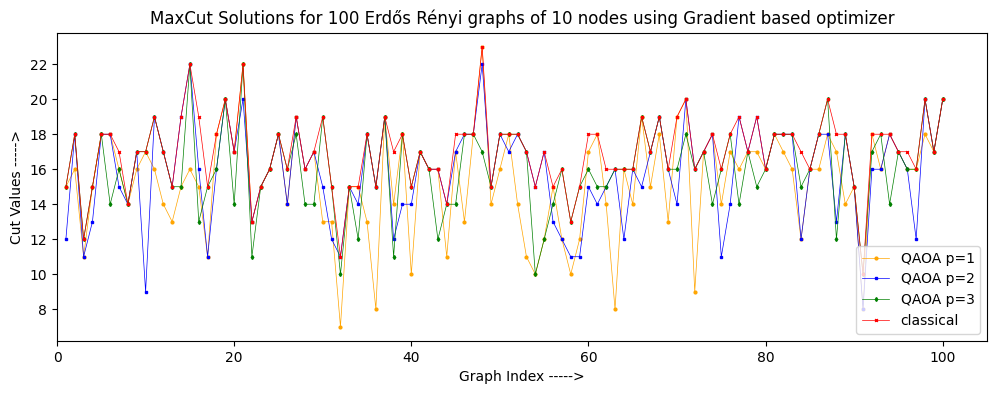

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  # Width: 12 inches, Height: 6 inches
plt.xlim(0,105)
plt.plot(B[0], B[1], label='QAOA p=1', marker='o', markersize=2, linewidth=0.5, color='orange')  # Red markers
plt.plot(B[0], B[2], label='QAOA p=2', marker='s', markersize=2, linewidth=0.5, color='blue')  # Blue markers
plt.plot(B[0], B[3], label='QAOA p=3', marker='d', markersize=2, linewidth=0.5, color='green')  # Green markers
plt.plot(B[0], B[4], label='classical', marker='x', markersize=2, linewidth=0.5, color='red')  # Black markers

#plt.grid()
plt.xlabel("Graph Index ----->")
plt.ylabel("Cut Values ----->")
plt.title("MaxCut Solutions for 100 Erdős Rényi graphs of 10 nodes using Gradient based optimizer")
plt.legend(loc='lower right')
plt.savefig('grad_100_graphs.png', dpi=600)

Plotting bar plot for average normalized maxcut for different methods

For Gradient based Maxcut normalized wrt classical method :  [1.0, 0.8999481980867425, 0.9311214489134803, 0.9424438808992415]


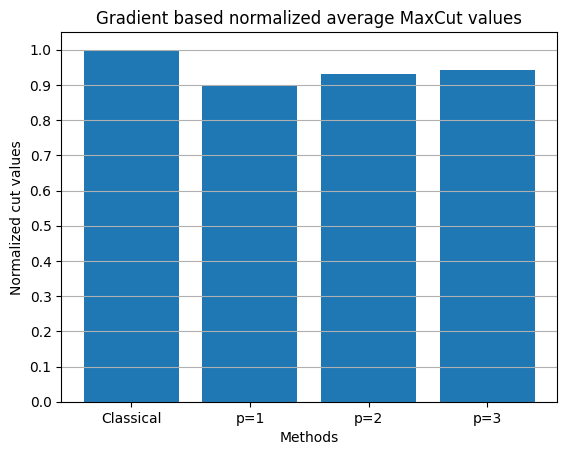

In [64]:
D=[1.]
for j in range(0,3,1):
    s = 0
    for i in range(0,100,1):
        s += B[j+1][i]/B[4][i]
    s = s/100
    D.append(float(s)) 
E = ['Classical','p=1','p=2','p=3']
print("For Gradient based Maxcut normalized wrt classical method : ",D)
plt.bar(E,D)
plt.title('Gradient based normalized average MaxCut values')
plt.xlabel("Methods")
plt.grid(axis='y')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Normalized cut values")
plt.savefig('grad_bar_plot.png', dpi=600)